# Echograms preparation

Here we try to retrieve data from the "Echointegration.mat" obtained during the ABRACOS1 campaign, then turning into a `torch.Tensor()` before making various crops in order to build a `Dataset`.

## 0. Getting setup and retrieving data

In [69]:
# Importing necessary modules
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import math

try:
    import h5py
except:
    print("Couldn't find h5py extension, installing it.")
    !pip install h5py
    import h5py

import torch

In [10]:
# Setting up working directory and retrieving data

os.chdir("C:\\Users\\Gaspard\\Desktop\\Etudes\\L'X\\Stage 3A - MARBEC\\Data\\ABRACOS1\\EI002_High_resolution")
print(f"Current working directory: {os.getcwd()}")

# Retrieving .mat data with h5py.File (scipy.io.loadmat doesn't work on v7.3 files)
EI = h5py.File('Echointegration.mat','r')
EI

Current working directory: C:\Users\Gaspard\Desktop\Etudes\L'X\Stage 3A - MARBEC\Data\ABRACOS1\EI002_High_resolution


<HDF5 file "Echointegration.mat" (mode r)>

In [31]:
Sv_surface_array = np.array(EI.get("Sv_surface"))
Sv_surface_tensor = torch.from_numpy(Sv_surface_array)
print(f"Sv_surface shape: {Sv_surface_tensor.shape} -> [color_channels (4), width, height] (CWH)")

Sv_surface shape: torch.Size([4, 415019, 745]) -> [color_channels (4), width, height] (CWH)


In [32]:
# Reshaping to CHW (torchvision's standard format)
Sv_surface_tensor = Sv_surface_tensor.permute(0, 2, 1)
print(f"New shape: {Sv_surface_tensor.shape} -> CHW")

New shape: torch.Size([4, 745, 415019]) -> CHW


## 1. Visualizing part of the data

In order to visualize the data, we will have to keep only 3 frequences, so we will discard the 4th one (200kHz).

In [142]:
HEIGHT = 745
WIDTH = 1000

Sv_image = Sv_surface_tensor[:3, :HEIGHT, :WIDTH]
Sv_image = np.array(Sv_image.permute(1, 2, 0))
print(f"Image shape: {Sv_image.shape} -> HWC")

Image shape: (745, 1000, 3) -> HWC


In [143]:
Sv_image[0, 0, :]

array([-150., -150., -150.], dtype=float32)

In [144]:
Sv_image.min(), Sv_image.max()

(nan, nan)

We need to project `Sv_image` values (logarithmic echogram values) into RGB values ([0, 255] for int, [0, 1] for float). A possibility is to simply offset the intensities.

We will then replace the `NaN` values by 0.

In [145]:
Sv_image += 150
Sv_image.min(), Sv_image.max()

(nan, nan)

In [146]:
# Need to replace NaN by 0 for better visualization

for h in range(HEIGHT):
     for w in range(WIDTH):
            for c in range(3):
                if math.isnan(Sv_image[h, w, c]):
                    Sv_image[h, w, c] = 0
Sv_image.min(), Sv_image.max()

(0.0, 98.74206)

In [147]:
Sv_image = Sv_image.astype(int)

In [148]:
Sv_image.min(), Sv_image.max()

(0, 98)

Text(0.5, 1.0, 'Top left corner of the echogram, size = 1000x745')

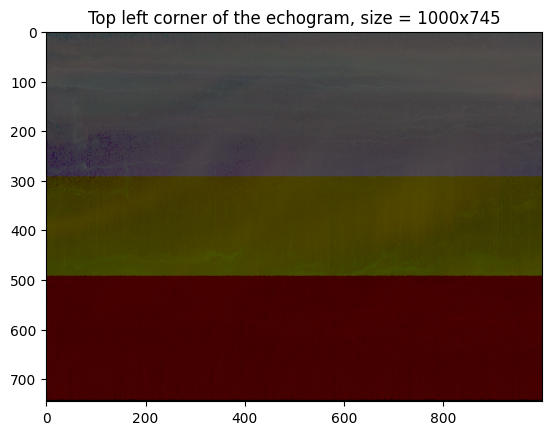

In [149]:
plt.figure()
plt.imshow(Sv_image)

plt.title(f"Top left corner of the echogram, size = {WIDTH}x{HEIGHT}")

We seem to have a contrast issue. Let's see what can be done about it.

Text(0.5, 1.0, 'Top left corner of the echogram, size = 1000x745')

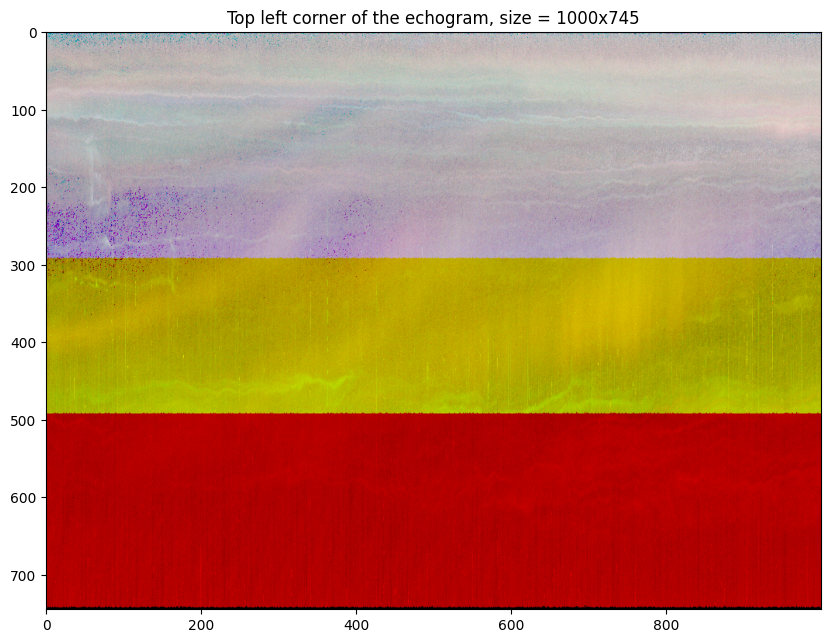

In [152]:
# Increasing contrast

# Get brightness range - i.e. darkest and lightest pixels
min=np.min(Sv_image)        # result=144
max=np.max(Sv_image)        # result=216

# Make a LUT (Look-Up Table) to translate image values
LUT=np.zeros(256,dtype=np.uint8)
LUT[min:max+1]=np.linspace(start=0,stop=255,num=(max-min)+1,endpoint=True,dtype=np.uint8)

Sv_image_contrasted = LUT[Sv_image]
plt.figure(figsize=(10, 10))
plt.imshow(Sv_image_contrasted)

plt.title(f"Top left corner of the echogram, size = {WIDTH}x{HEIGHT}")